In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# import deeplake
# ds = deeplake.load("hub://activeloop/ffhq")
# ds.summary()
# print(ds.tensors['images_128/image'].shape)

In [6]:
dirpath = 'images/thumbnails_jpg'
filenames = os.listdir(dirpath)
img_paths = [dirpath + f"/{filename}" for filename in filenames]
print(len(img_paths))

70000


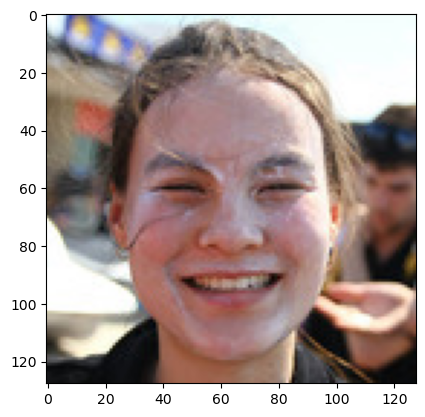

In [7]:
#Import image
sample = img_paths[4]
image = cv2.imread(sample)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
H, W = 128, 128  # Not sure if H, W or W, h
N = len(img_paths)
images_hls = np.zeros((N, 128, 128, 3), dtype=np.uint8)
for i, path in tqdm(enumerate(img_paths), total=N):
    img = cv2.imread(path)
    images_hls[i] = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

100%|███████████████████████████████████| 70000/70000 [00:24<00:00, 2900.24it/s]


In [9]:
images_hls.shape

(70000, 128, 128, 3)

In [10]:
n_images = 100
X = images_hls[:n_images, :, :, 1]  # Keeping L channel
Y = images_hls[:n_images, :, :, [0, 2]]  # Keeping H and S channels
X.shape, Y.shape

((100, 128, 128), (100, 128, 128, 2))

In [11]:
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential

In [12]:
#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
# Finish model
model.compile(optimizer='rmsprop', loss='mse')

2022-10-25 14:16:47.522824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 14:16:47.525315: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 512)       1

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 50
def image_a_b_gen(X, batch_size):
    for batch in datagen.flow(X, batch_size=batch_size):
        hls_batch = [cv2.cvtColor(img, cv2.COLOR_BGR2HLS) for img in batch]
        hls_batch = np.array(hls_batch)
        X_batch = hls_batch[:,:,:,1]
        Y_batch = hls_batch[:,:,:,[0, 2]] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [14]:
model.fit_generator(X, Y, batch_size=8, verbose=1)

13/13 [==============================] - 9s 628ms/step - loss: 7765.6006
